# Data Wrangling
In the very begining we need to make sure the data is decent for modeling.

In [47]:
# data analysis pkg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

# data wrangling, cleaning and wordcloud visualization pkg
from hazm import word_tokenize, stopwords_list, InformalLemmatizer
import re
import arabic_reshaper
from bidi.algorithm import get_display
from wordcloud import WordCloud

from tqdm import tqdm as progressbar

# Avoiding warnings
import warnings
import os
########### Prevent Warnings ###########
warnings.filterwarnings(action='ignore')
########### Prevent Warnings ###########

%matplotlib inline

## Read data

In [62]:
df = pd.read_csv('data/original/train.csv')

In [63]:
df.head()

,id,title,comment,rate,verification_status
0,0,کیفیت و حجم صدای عااااالی,این محصول توی بازار اصلاااا پیدا نمیشه من کل ت...,100.0,0
1,1,شش ماه مصرف!!,دوبار از این مدل گرفتم اولاش خوبه ولی بعد از ش...,5.0,0
2,2,کارآیی,به نظر من فقط برای کارای سبک و دیدن فیلم و مطا...,60.0,0
3,3,بررسی کمی و کیفی,برای من بسیار مناسب و خریدش در شگفت انگیز حتما...,0.0,0
4,4,بسته بندی ضعیف,ظاهر بامزه ای داره ولی عکسش شبیه خودش نیست جنس...,60.0,0


#### All data is from unique ids?

In [26]:
df.id.nunique()

180000

- Yes they are.

## Do we have null data?

In [65]:
df.isnull().sum()

id                        0
title                  4837
comment                 122
rate                      0
verification_status       0
dtype: int64

### Deleting rows with both comment and title set as null
its an NLP project and texts are most valuable data we have.
So we delete rows which have null in both comment and title

In [28]:
df = df[~((df.title.isnull()) & (df.comment.isnull()))]
df = df.reset_index(drop=True)

### Check data types

In [29]:
df.dtypes

id                       int64
title                   object
comment                 object
rate                   float64
verification_status      int64
dtype: object

- set title and comment as str

In [56]:
def set_types(df):
    df.title = df.title.astype(str)
    df.comment = df.comment.astype(str)
    df.rate = df.rate.astype('int')
    return df
df = set_types(df)

### Replacing nans
- We're going to replace nans in title and comment columns with symbol # before merging these columns.
- In next steps we take care of Symbol # for filteration

In [31]:
def replace_nan(entry):
    if entry == 'nan':
        return '#'
    return entry
df.title = df.title.apply(replace_nan)
df.comment = df.comment.apply(replace_nan)

### inserting new column namely as text and combining both comment and title in them

In [32]:
df['text'] = df['title'] + ' ' + df['comment']
# swap text and target values
# And also exclude id colmn => No longer is needed
df = df.reindex(columns=['title', 'comment', 'text', 'rate', 'verification_status'])
df.head(1)

,title,comment,text,rate,verification_status
0,کیفیت و حجم صدای عااااالی,این محصول توی بازار اصلاااا پیدا نمیشه من کل ت...,کیفیت و حجم صدای عااااالی این محصول توی بازار ...,100,0


### Let's check out the target values density

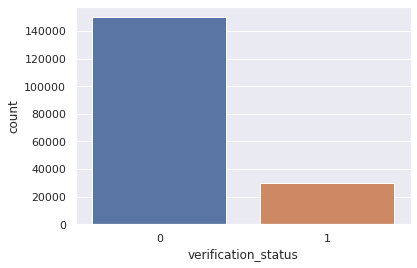

In [33]:
df.verification_status = df.verification_status.astype('category')
sns.countplot(df.verification_status)

- Looks like we got imbalanced dataset

- Soon enough we investigate the dataset with wordcloud to see if WordCLoud result can confirm this one.

## Data distribution with considering verification status and the length of texts
Check out the texts kernel density based on length

### Q: How does data distribute in terms of text length for both verification status

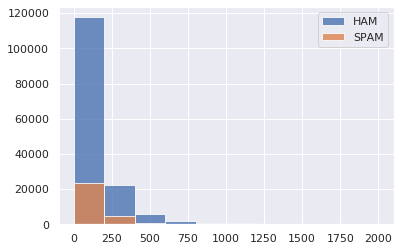

In [34]:
# length between [0-2000]

plt.hist(df[df['verification_status']==0].text.str.len(),alpha=0.8, range=(0, 2000))
plt.hist(df[df['verification_status']==1].text.str.len(),alpha=0.8, range=(0, 2000))
plt.legend(('HAM', 'SPAM'))

- seems that we have texts longer than 4000 characters.
- Let's get down deeper

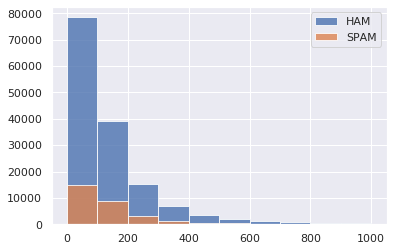

In [35]:
# length between [0-1000]
plt.hist(df[df['verification_status']==0].text.str.len(),alpha=0.8, range=(0, 1000))
plt.hist(df[df['verification_status']==1].text.str.len(),alpha=0.8, range=(0, 1000))
plt.legend(('HAM', 'SPAM'))

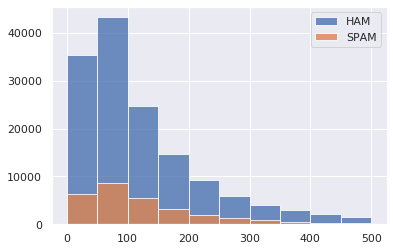

In [36]:
# length between [0-500]
# Can set cumulative to true, to see the cumulative plot
plt.hist(df[df['verification_status']==0].text.str.len(),alpha=0.8, range=(0, 500))
plt.hist(df[df['verification_status']==1].text.str.len(),alpha=0.8, range=(0, 500))
plt.legend(('HAM', 'SPAM'))

## Are there anomalies based on text length?

In [37]:
df.text.groupby(pd.cut(df.text.str.len(), np.arange(0,8000,500))).count()

text
(0, 500]        172424
(500, 1000]       5960
(1000, 1500]      1020
(1500, 2000]       304
(2000, 2500]       129
(2500, 3000]        57
(3000, 3500]        27
(3500, 4000]        12
(4000, 4500]        10
(4500, 5000]         7
(5000, 5500]         3
(5500, 6000]         2
(6000, 6500]         1
(6500, 7000]         2
(7000, 7500]         1
Name: text, dtype: int64

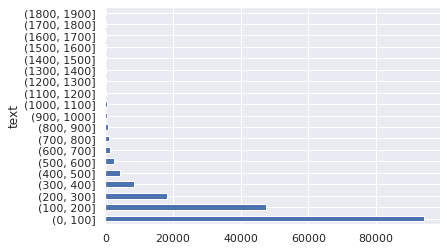

In [39]:
df.text.groupby(pd.cut(df.text.str.len(), np.arange(0,2000,100))).count().\
plot(kind='barh')

In [40]:
# Who's the longest?
df[df.comment.str.len() == max(df.comment.str.len())]

,title,comment,text,rate,verification_status
174244,اگه تو خریدش دو دل هستید حتما بخونید...,ببینید دوستان من به عنوان یک گوشی باز حرفه ای ...,اگه تو خریدش دو دل هستید حتما بخونید... ببینید...,81,0


In [41]:
# How many?
df.text.groupby(pd.cut(df.text.str.len(), np.arange(0,2000,100))).count()

text
(0, 100]        94255
(100, 200]      47323
(200, 300]      18255
(300, 400]       8315
(400, 500]       4276
(500, 600]       2425
(600, 700]       1435
(700, 800]        955
(800, 900]        664
(900, 1000]       481
(1000, 1100]      331
(1100, 1200]      252
(1200, 1300]      181
(1300, 1400]      165
(1400, 1500]       91
(1500, 1600]       79
(1600, 1700]       83
(1700, 1800]       49
(1800, 1900]       52
Name: text, dtype: int64

Let's drop the texts with length exceeded over 2500 characters.

In [42]:
df = df[df.text.str.len()<=2000]
df = df.reset_index(drop=True)
df.shape

(179708, 5)

## Check the titles

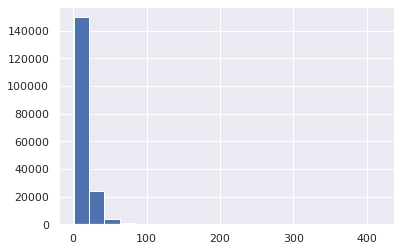

In [15]:
plt.hist(df.title.str.len(), bins=20, label='train')
plt.show()

In [16]:
df[(df.title.str.len() > 300)].count()

title                  6
comment                6
text                   6
rate                   6
verification_status    6
dtype: int64

In [17]:
df.title.groupby(pd.cut(df.title.str.len(), np.arange(0,400,20))).count()

title
(0, 20]       146554
(20, 40]       26670
(40, 60]        4035
(60, 80]        1211
(80, 100]        487
(100, 120]       254
(120, 140]       175
(140, 160]       104
(160, 180]        67
(180, 200]        60
(200, 220]        37
(220, 240]        28
(240, 260]        15
(260, 280]         2
(280, 300]         3
(300, 320]         1
(320, 340]         0
(340, 360]         1
(360, 380]         3
Name: title, dtype: int64

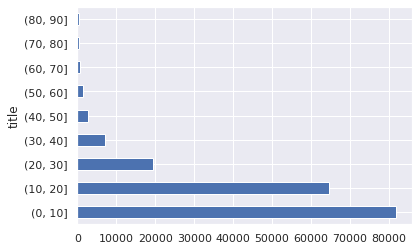

In [18]:
df.title.groupby(pd.cut(df.title.str.len(), np.arange(0,100,10))).count().\
plot(kind='barh')

## Are there duplicates rows in comment and title?
#### duplicated rows with both comment and title are of no use for model

In [43]:
df[(df.duplicated(subset=['comment', 'title']))].count()

title                  609
comment                609
text                   609
rate                   609
verification_status    609
dtype: int64

**609 duplicates are found, Lets get rid of them**

In [44]:
df.drop_duplicates(subset =['comment', 'title'], inplace = True)

# Modify ratings to a categorical item
#### The ratings are in continuous format. so interpreting the continuous data along with the text processing is a little bit difficult for model to handle. Using categorical data is much better

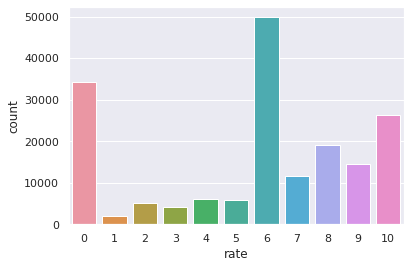

In [45]:
df.rate = df.rate.apply(lambda x: int(x// 10))
df.rate = df.rate.astype('category')
sns.countplot(df.rate)

# Is there any relationship between rate and verification status?
- Let's check that out

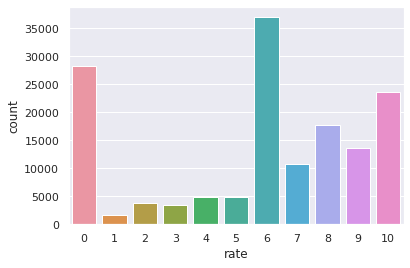

In [95]:
sns.countplot(df[df['verification_status']==0].rate)

**The Plot for Hams (Comments with no spam)**

Three common numbers -> [0 , 6 , 10]


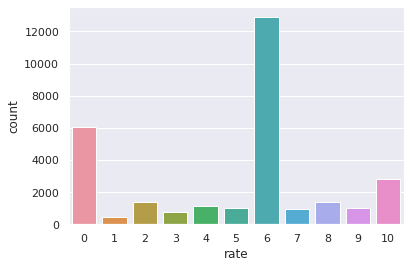

In [96]:
sns.countplot(df[df['verification_status']==1].rate)

**The Plot for Spams**

Three common numbers -> [0 , 6 , 10]

- number 10s and number 0s has decreased proportional to 6 comparing to last plot.

- Obviously the most spam comments belong to people who are unhappy with products. so that explains why number 6 to 10 had a big decrease.

### Preprocess the data
##### The most important part of course is preprocessing texts. the following are some useful functions for manipulating texts

In [48]:
lemma = InformalLemmatizer()

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py  emoticons list
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt Chat shortcuts

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r' ', text)

def remove_punctuations(text):
    punctuations = re.compile(r'[~`!@#$%^&*(,<،>){}\\/|\'"?؟_+-=~\[\]]')
    return punctuations.sub(r' ', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r' ', text)

def remove_weird_chars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    patterns = [re.compile('\r'), re.compile('\n'), re.compile('&amp;')]
    text = weridPatterns.sub(r'', text)
    for p in patterns:
        text = p.sub(r' ', text)
    return text

def remove_extra_repeated_alpha(text):
    """
    Remove extra repeated alphabets in a word
    check these links:
    demo : https://regex101.com/r/ALxocA/1
    Question: https://bit.ly/2DoiPqS
    """
    return re.sub(r'([^\W\d_])\1{2,}', r'\1', text)


def clean_up(text, url=True, html=True, weird_patterns=True , lemmatize=False, 
               stopwords=True, isalpha=False, punctuations=True, remove_extra_alpha=True):
    # remove url
    if url:
        text = remove_urls(text)
    # remove html tags
    if html:
        text = remove_html(text)
    # remove emokis / symbols & pictographs / transport & map symbols / flags (iOS)
    if weird_patterns:
        text = remove_weird_chars(text)
    # remove punctuations
    if punctuations:
        text = remove_punctuations(text)
    # Alter words with repeated alphabets
    if remove_extra_repeated_alpha:
        text = remove_extra_repeated_alpha(text)
    # tokenize text
    tokens = word_tokenize(text)
    # remove stop words
    if stopwords:
        tokens = [word for word in tokens if word not in stopwords_list()]
    # remove non-alphabetic items
    if isalpha:
        tokens = [word for word in tokens if word.isalpha()]
    # lemmatize words
    if lemmatize:
        tokens = [lemma.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    
    return text

# df[df.comment.str.len()>4000].head(10)
# a = df.iloc[60659].comment
# a
# preprocess(str(a))


# Test the clean_up function before we apply it on whole dataset

In [49]:
df[df.text.str.len() > 1900].head()

,title,comment,text,rate,verification_status
2411,بسته به نیازتون خرید کنید,خب بعد از استفاده یه ماهه از این محصول نظر میز...,بسته به نیازتون خرید کنید خب بعد از استفاده یه...,8,0
6350,یک پکیج کامل از باگ ها و نقص ها و ایرادات نرم ...,با سلام خدمت دوستای گلم\r\nاقا اگه از اون دسته...,یک پکیج کامل از باگ ها و نقص ها و ایرادات نرم ...,9,0
6393,نکات قابل توجه در نگهداری از این موتور,سلام دوستان می خوام یه سری از نکات فنی رو در ر...,نکات قابل توجه در نگهداری از این موتور سلام دو...,7,1
11745,عالیه,من این لپتاپ رو دقیقا با این مشخصات از نمایندگ...,عالیه من این لپتاپ رو دقیقا با این مشخصات از ن...,9,0
11793,یکی از بهترین ها,با سلام خدمت همگی.این نطری که به اشتراک میذارم...,یکی از بهترین ها با سلام خدمت همگی.این نطری که...,9,0


In [50]:
a = df.loc[6393].comment
a

'سلام دوستان می خوام یه سری از نکات فنی رو در رابطه با نگهداری از این موتور به شما بگم که حتما این موارد رو چک کنید و انجام بدید :\r\nنکته اول این است که اول که موتور را تحویل گرفتید همه جای موتور چک کنید و از سلامت تمام اجزای موتور مثل ترمز استارت چراغ ها و لاستیک ها اطمینان حاصل کنید.\r\n\r\nنکته دوم اینکه روغن موتور اولیه این موتور رو که کارخونه در انجین این موتور ریخته را بعد از ۵۰ کیلومتر عوض کنید و میتوانید از روغن بهران سوپر پیشتاز استفاده کنید.\r\n\r\nنکته سوم اینکه هیچ وقت نزارید میزان بنزین در باک تون به کمتر از ۴ لیتر برسد چون اگر کمتر از ۲ لیتر بشه ممکنه پمپ بنزین زیر باک تون بسوزه و همیشه سعی کنید از بنزین با اکتان بالا مثل بنزین سوپر استفاده کنید\r\n\r\nنکته چهارم اینکه بعد از اولین روغنی که در کیلومتر ۵۰ در موتور تون ریختید بعد از ۳۰۰ تا ۴۰۰ کیلومتر مجدد روغن موتور تون رو عوض کنید البته این رو اضافه کنم که بعد از ۲۰۰ کیلومتر شما می بایستی به گارانتی مراجعه کنید تا آچار کشی اولیه و چکاپ اولیه موتور رو انجام بدن.\r\n\r\nنکته پنجم اینکه باد لاستیک تون رو روی عدد ۳۰ تنظیم کن

In [51]:
clean_up(a)

'سلام دوستان خوام یه سری نکات فنی رابطه نگهداری موتور بگم حتما موارد چک انجام بدید نکته موتور تحویل گرفتید موتور چک سلامت اجزای موتور ترمز استارت چراغ ها لاستیک ها اطمینان حاصل نکته روغن موتور اولیه موتور کارخونه انجین موتور ریخته ۵۰ کیلومتر عوض میتوانید روغن بهران سوپر پیشتاز استفاده نکته وقت نزارید میزان بنزین باک تون کمتر ۴ لیتر برسد کمتر ۲ لیتر بشه ممکنه پمپ بنزین باک تون بسوزه بنزین اکتان بنزین سوپر استفاده نکته روغنی کیلومتر ۵۰ موتور تون ریختید ۳۰۰ ۴۰۰ کیلومتر مجدد روغن موتور تون عوض اضافه ۲۰۰ کیلومتر بایستی گارانتی مراجعه آچار کشی اولیه چکاپ اولیه موتور انجام بدن نکته پنجم باد لاستیک تون عدد ۳۰ تنظیم نکته ششم وقت کیلومتر ۱۰۰۰ موتور تون فشار نیارید موتور پایین رانندگی ۶۰ الی ۷۰ باهاش رانندگی نکنید موتور تون آب بشه نکته آخر ترین خوام بهتون بگم خودم فلاپ چپ درپوش باتری موتور سیکلت کشف اینه لوله های موتور سمبل اشتباه شرکت پیچ های بدنه موتور چسبیده داغ ممکنه لوله آب بشه سوراخ بشه خودم اتفاقی بیفته لوله بست پلاستیکی عقب کشیدم لوله پلاستیکی موتور توسط پیچ آب سوراخ نشده میخواین بدونین ل

In [53]:
for index, row in progressbar(df.iterrows(), total=df.shape[0]):
    row = row.copy()
    comment = remove_punctuations(row.comment)
    title = remove_punctuations(row.title)
    text = remove_punctuations(row.text)
    df.loc[index, 'title'] = title
    df.loc[index, 'comment'] = comment
    df.loc[index, 'text'] = text

# Save preprocessed data
df.to_csv('data/cleaned/data.csv', index=False)

 41%|████      | 72735/179099 [2:10:54<3:24:56,  8.65it/s]

KeyboardInterrupt: 

In [54]:
# read preprocessed data 
df = pd.read_csv('data/cleaned/data.csv')

## Word_cloud for titles

In [57]:
df = set_types(df)
df.text = df.text.apply(str)

In [58]:
all_words_title = ' '.join([text for text in df.title])
all_words = arabic_reshaper.reshape(all_words_title)

In [59]:
all_words = get_display(all_words)

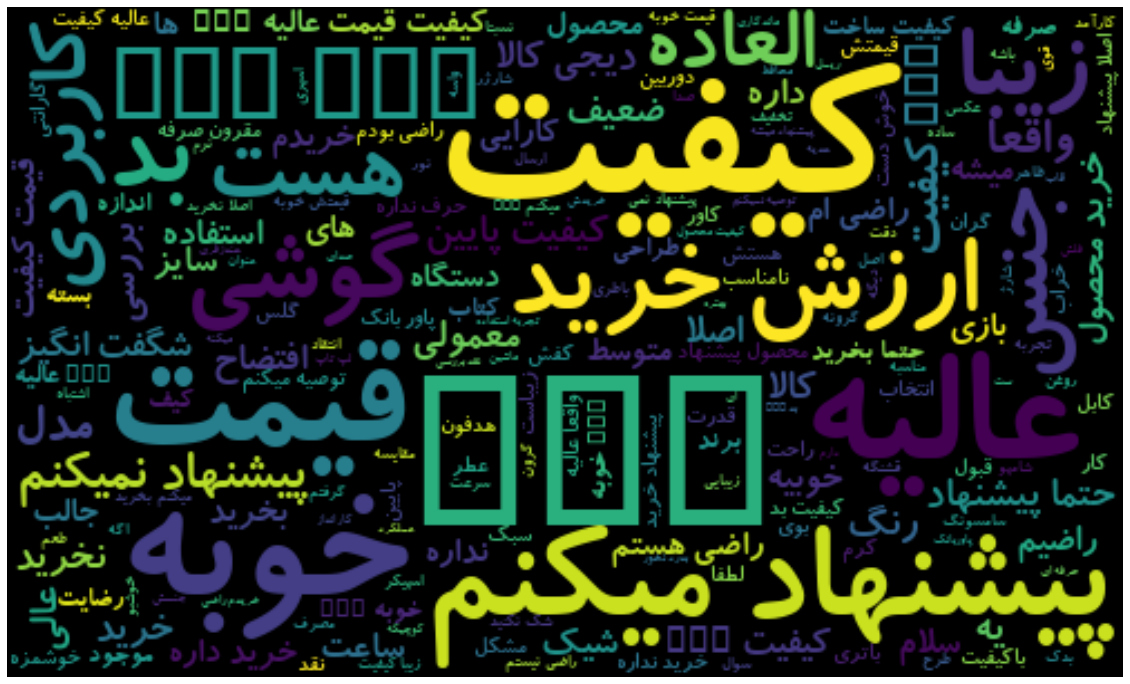

In [60]:
# https://stackoverflow.com/questions/49384111/reflect-arabic-word-cloud
wordcloud = WordCloud(font_path="./fonts/B Koodak Bold_YasDL.com.ttf", 
                      width=500, height=300, 
                      random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

## word cloud for comments

In [26]:
all_words_comment = ' '.join([text for text in df.comment])
all_words = arabic_reshaper.reshape(all_words_comment)

In [27]:
all_words = get_display(all_words)

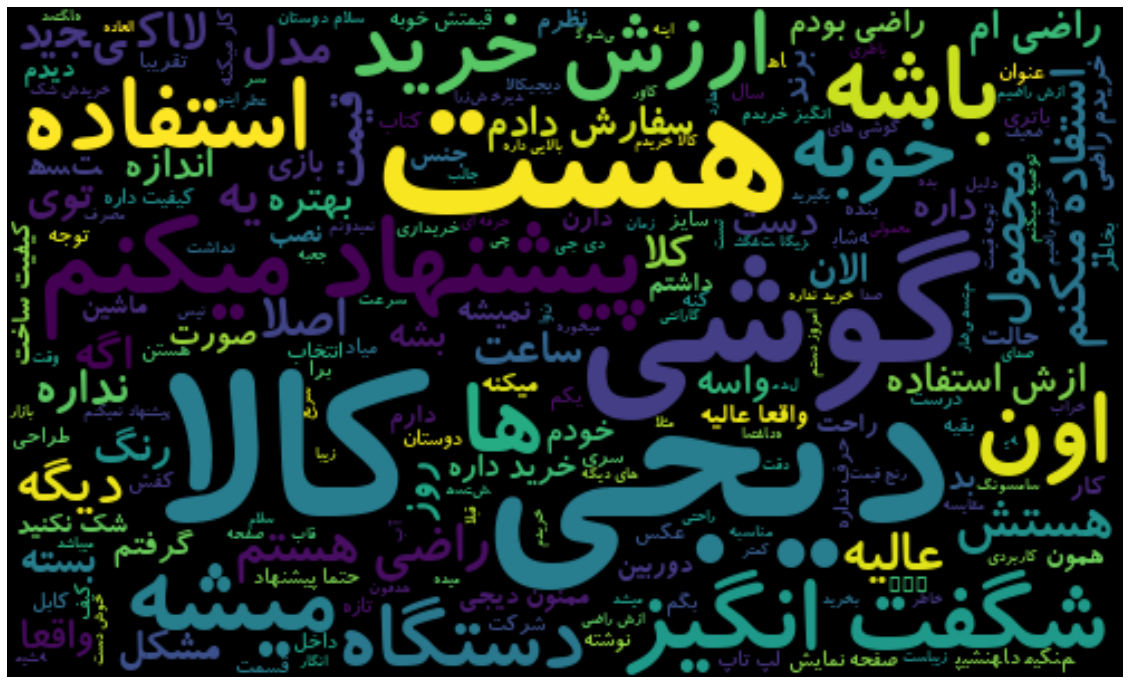

In [29]:
wordcloud = WordCloud(font_path="./fonts/B Koodak Bold_YasDL.com.ttf", 
                      width=500, height=300, 
                      random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

## Word cloud for Spams
Let's see if words are different in spams and hams

In [5]:
all_words_comment = ' '.join([text for text in df[df.verification_status == 0].comment])
all_words = arabic_reshaper.reshape(all_words_comment)

In [6]:
all_words = get_display(all_words)

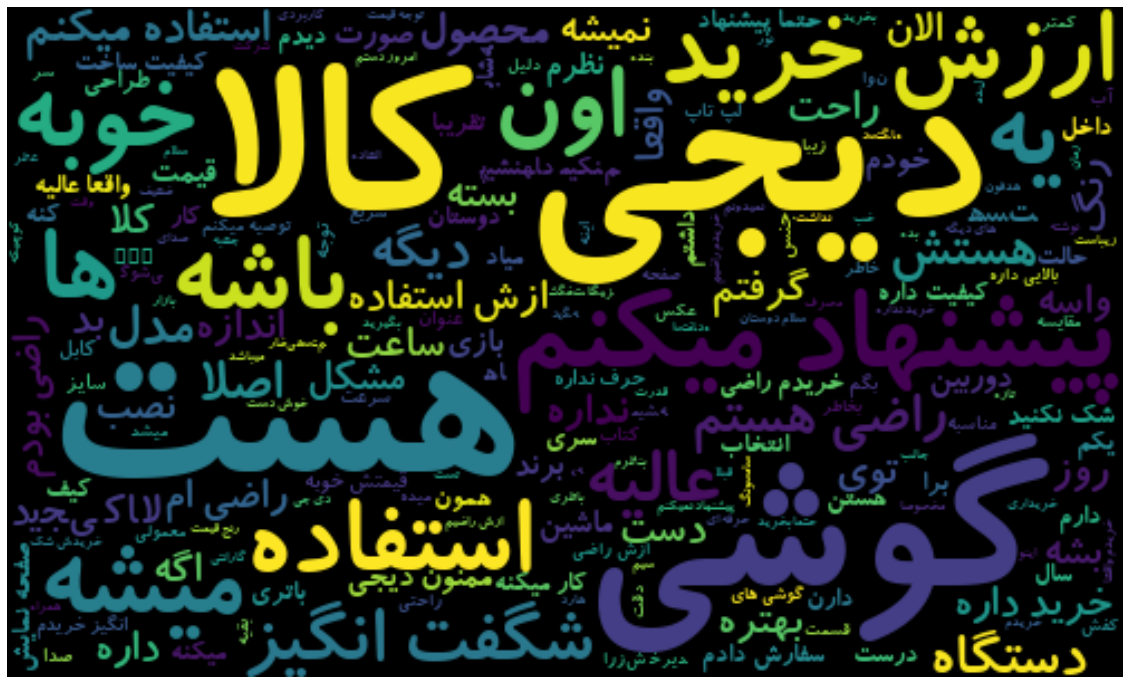

In [7]:
wordcloud = WordCloud(font_path="./fonts/B Koodak Bold_YasDL.com.ttf", 
                      width=500, height=300, 
                      random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

## Word cloud for Hams

In [8]:
all_words_comment = ' '.join([text for text in df[df.rate == 1].comment])
all_words = arabic_reshaper.reshape(all_words_comment)

In [9]:
all_words = get_display(all_words)

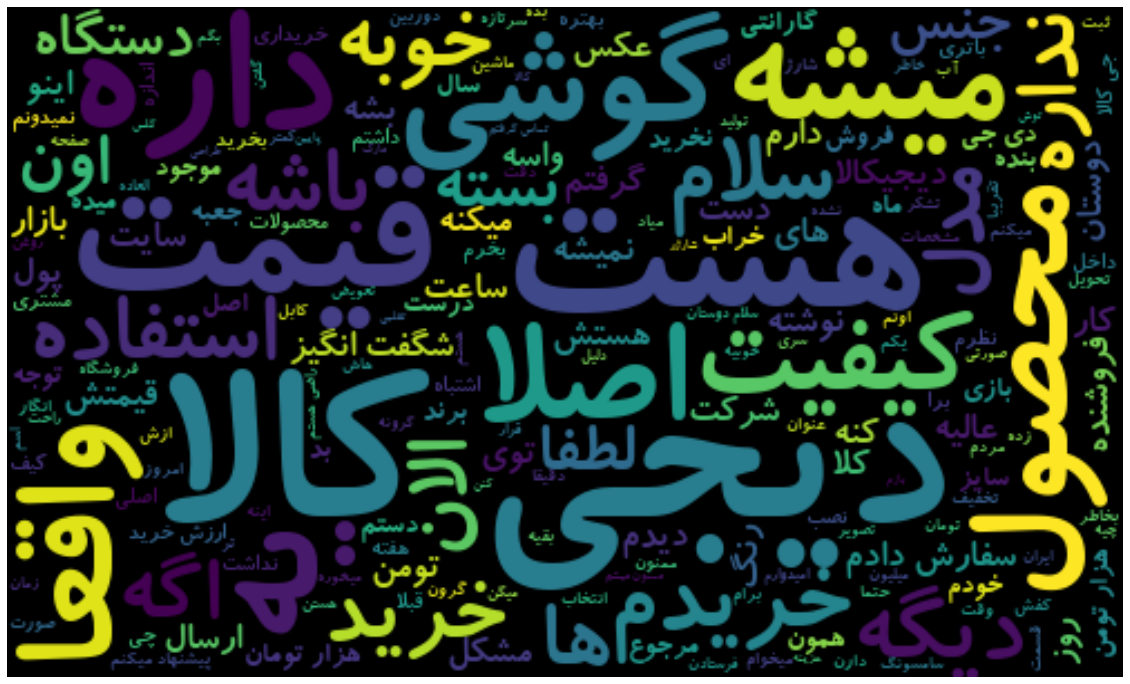

In [10]:
wordcloud = WordCloud(font_path="./fonts/B Koodak Bold_YasDL.com.ttf", 
                      width=500, height=300, 
                      random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

## How about low ratings?

In [11]:
all_words_comment = ' '.join([text for text in df[df.rate <= 5].comment])
all_words = arabic_reshaper.reshape(all_words_comment)

In [12]:
all_words = get_display(all_words)

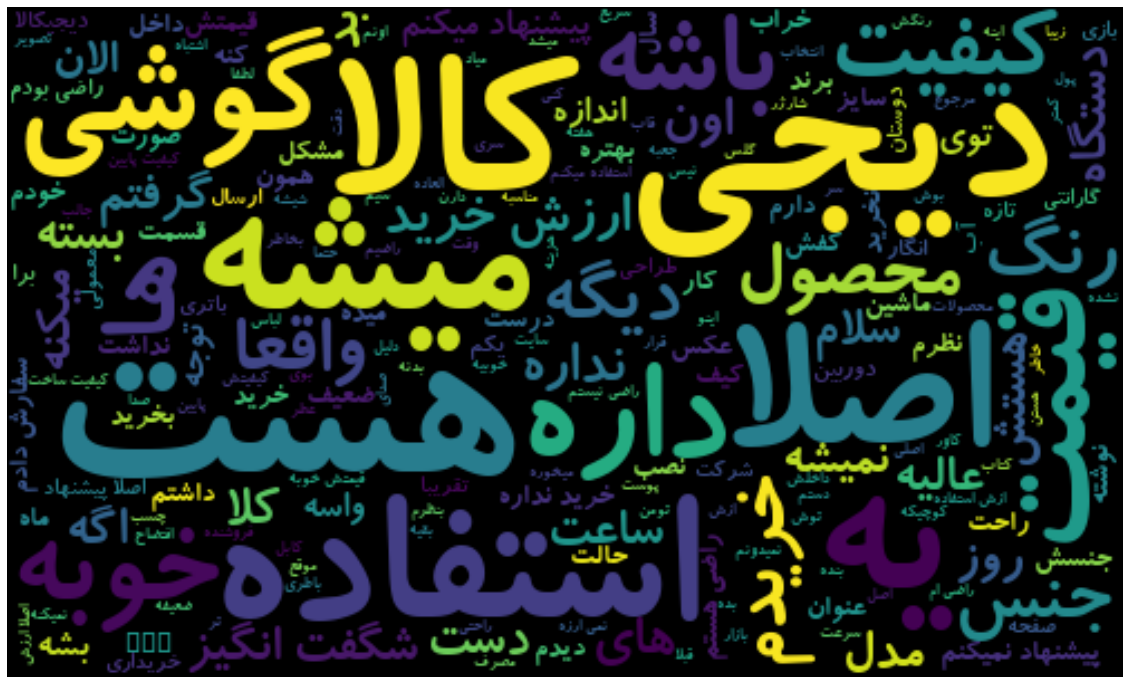

In [13]:
wordcloud = WordCloud(font_path="./fonts/B Koodak Bold_YasDL.com.ttf", 
                      width=500, height=300, 
                      random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

- I don't see anything that sound like pattern